In [1]:
from h5py import File
from numpy import array
from scipy.stats import skew,kurtosis
from numpy import mean, trapz, vstack, concatenate,std
import matplotlib.pyplot
import numpy 
import scipy
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as ft
import re
import numpy as np

from scipy.signal import lfilter, freqs, freqz, butter, buttord, bilinear

def range_freq(signal):
    fs=250
    N_size = len(signal);
    wHz=np.arange(N_size)*fs/N_size;
    return wHz

## Eyes open - close - open ##

### Pre-procesamiento ###

number of samples of channel 17500
number of samples of channel 27500


Text(0, 0.5, 'Amplitude')

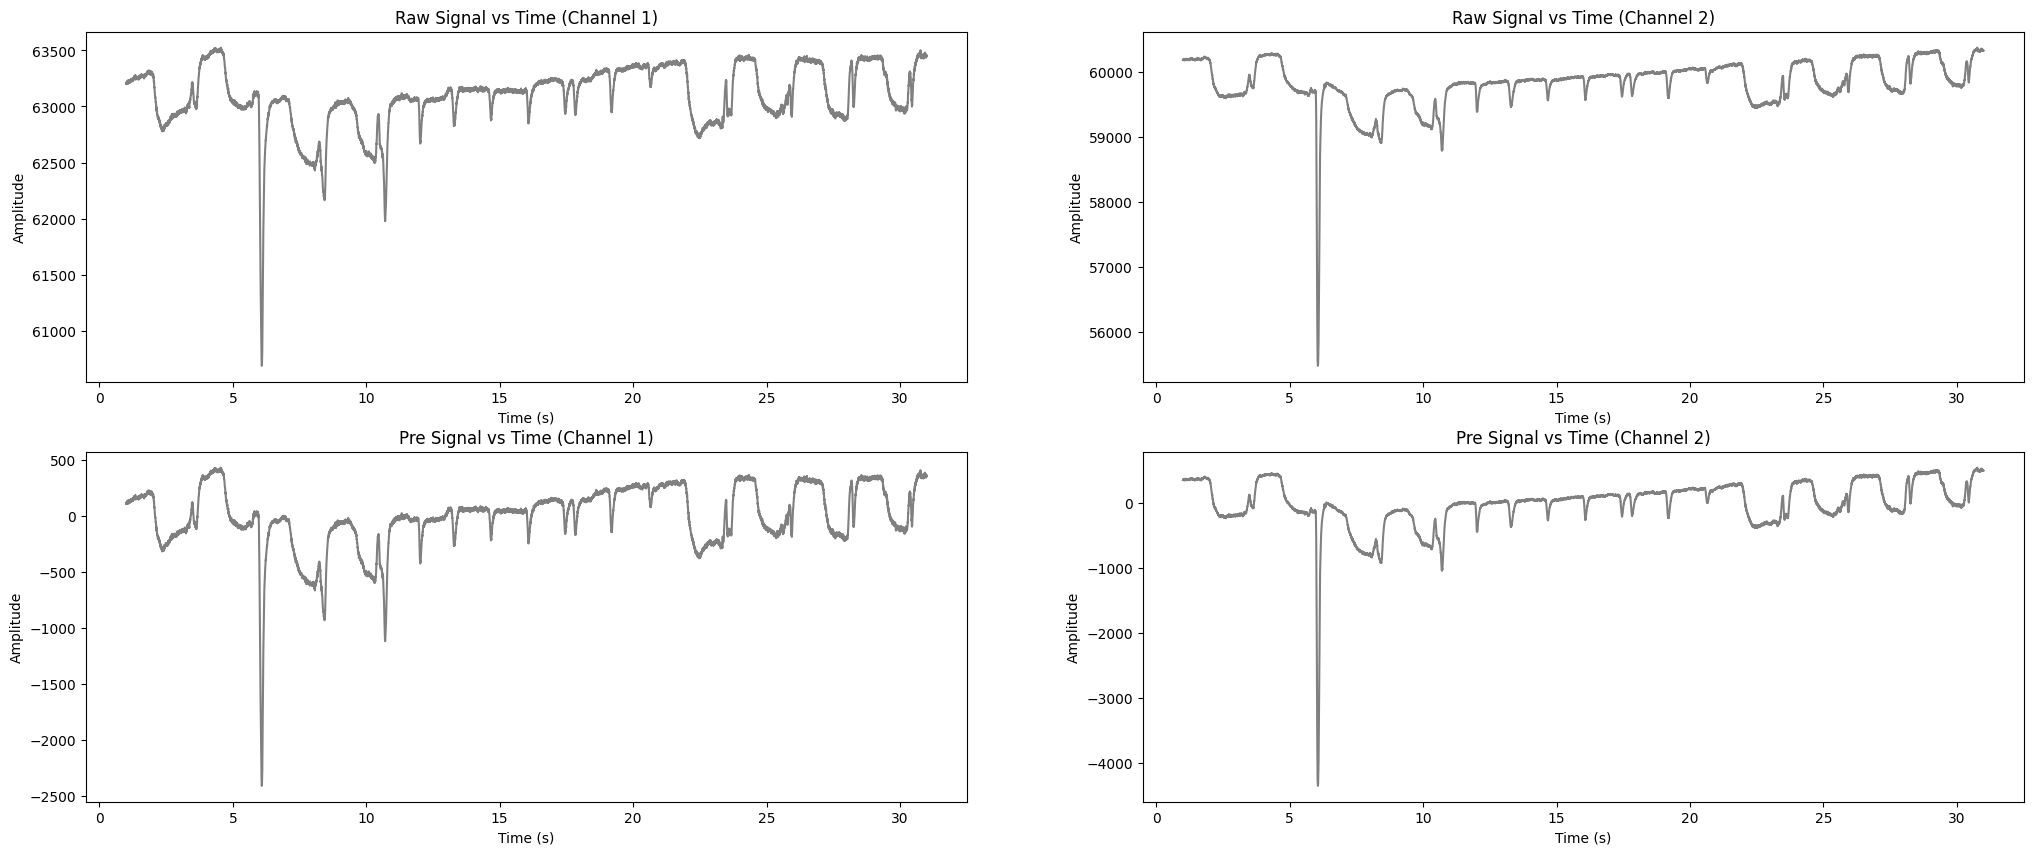

In [2]:
fs=250  #Obtenido de BCI
ts=1/fs

oco= np.genfromtxt("p_oco.txt", delimiter=", ",skip_header = 5)

M = oco[:,1].shape[0]
n = np.arange(0,M) #numero de muestras

t=n*ts
t1=250*1
t2=250*31
T=t[t1:t2]

c1=oco[t1:t2,1];pre_c1=c1-(sum(c1)/len(c1))
c2=oco[t1:t2,2];pre_c2=c2-(sum(c2)/len(c2))

print("number of samples of channel 1"+str(len(c1)))
print("number of samples of channel 2"+str(len(c1)))

plt.figure(1, figsize=(25,10))
plt.subplot(221)
plt.plot(T, c1,"grey");plt.title("Raw Signal vs Time (Channel 1)");plt.xlabel("Time (s)");plt.ylabel("Amplitude")
plt.subplot(222)
plt.plot(T, c2,"grey");plt.title("Raw Signal vs Time (Channel 2)");plt.xlabel("Time (s)");plt.ylabel("Amplitude")
plt.subplot(223)
plt.plot(T, pre_c1,"grey");plt.title("Pre Signal vs Time (Channel 1)");plt.xlabel("Time (s)");plt.ylabel("Amplitude")
plt.subplot(224)
plt.plot(T, pre_c2,"grey");plt.title("Pre Signal vs Time (Channel 2)");plt.xlabel("Time (s)");plt.ylabel("Amplitude")

Low pass filter
Order: 16
Cut-off frequency: 0.7343808273539129
High pass filter
Order: 2
Cut-off frequency: 0.025163922029711554


Text(0, 0.5, 'Magnitude')

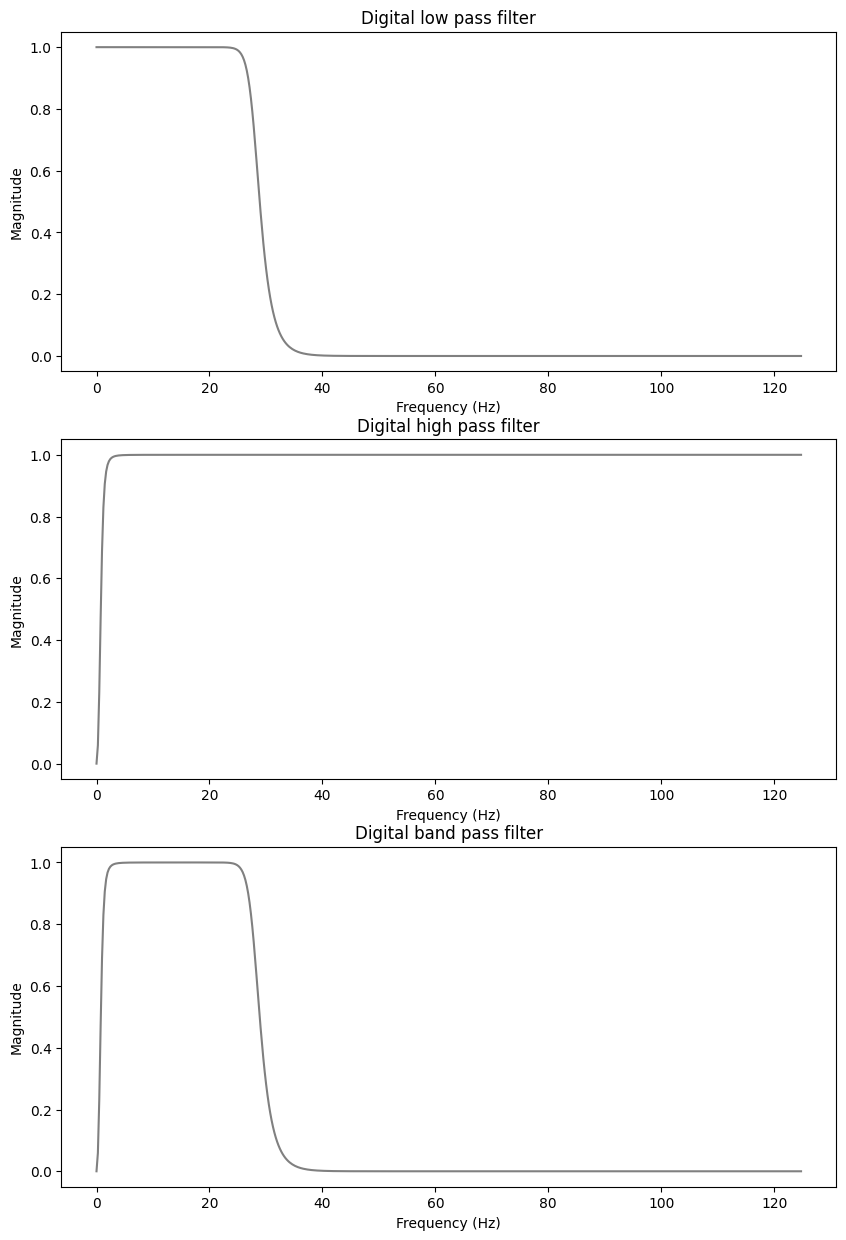

In [3]:
#Creacion del filtro IIR: Pasabanda y pasaalta
#Low pass:
fs=250
wp=2*np.pi*(28/fs)
ws=2*np.pi*(32/fs)

#Bilinear transformation
T=1
O_p=(2/T)*np.tan(wp/2); O_s=(2/T)*np.tan(ws/2)
Rp=20*np.log10(1/0.8); Rs=20*np.log10(0.1)

#Filter order
N_bil, W_bil=buttord(O_p,O_s,3,20,analog=True)

print("Low pass filter")
print("Order: "+str(N_bil))
print("Cut-off frequency: "+str(W_bil))

#Analog coefficients 
b_bil, a_bil=butter(N_bil, W_bil, analog=True)

#Analog frequency response
w,h_a=freqs(b_bil,a_bil)

#Creation of the digital filter
bd_bil_low,ad_bil_low=bilinear(b_bil,a_bil)
wd,hd=freqz(bd_bil_low, ad_bil_low)


#High pass
wp_1=2*np.pi*(1/fs)
ws_1=2*np.pi*(5/fs)

#Bilinear Transformation 
O_p1=(2/T)*np.tan(wp_1/2); O_s1=(2/T)*np.tan(ws_1/2)

#Filter order
N_bil1, W_bil1=buttord(O_p1,O_s1,3,20,analog=True)

print("High pass filter")
print("Order: "+str(N_bil1))
print("Cut-off frequency: "+str(W_bil1))

#Analog coefficients 
b_bil1, a_bil1=butter(N_bil1, W_bil1,btype="high", analog=True)

#Analog frequency response
w1,h1_a=freqs(b_bil1,a_bil1)

#Creation of the digital filter
bd_bil_high,ad_bil_high=bilinear(b_bil1,a_bil1)
wd1,hd1=freqz(bd_bil_high, ad_bil_high)

#Combination of both filters
f=[np.convolve(bd_bil_high,bd_bil_low),np.convolve(ad_bil_high,ad_bil_low)]
W,H=freqz(f[0],f[1])

#Graphs
plt.figure(1, figsize=(10,15))
plt.subplot(311)
f_low=wd*fs/(2*np.pi)
plt.plot(f_low,abs(hd),"gray");plt.title("Digital low pass filter");plt.xlabel("Frequency (Hz)");plt.ylabel("Magnitude")

plt.subplot(312)
f_high=wd1*fs/(2*np.pi)
plt.plot(f_high,abs(hd1),"gray");plt.title("Digital high pass filter");plt.xlabel("Frequency (Hz)");plt.ylabel("Magnitude")
         
plt.subplot(313)
f_band=W*fs/(2*np.pi)
plt.plot(f_band,abs(H),"gray");plt.title("Digital band pass filter");plt.xlabel("Frequency (Hz)");plt.ylabel("Magnitude")

In [4]:
#Filtering
fpre_c1=lfilter(f[0],f[1],pre_c1)
fpre_c2=lfilter(f[0],f[1],pre_c2)
time1=bsnb.generate_time(pre_c1,fs)
time2=bsnb.generate_time(pre_c2,fs)

Text(0, 0.5, 'Amplitude')

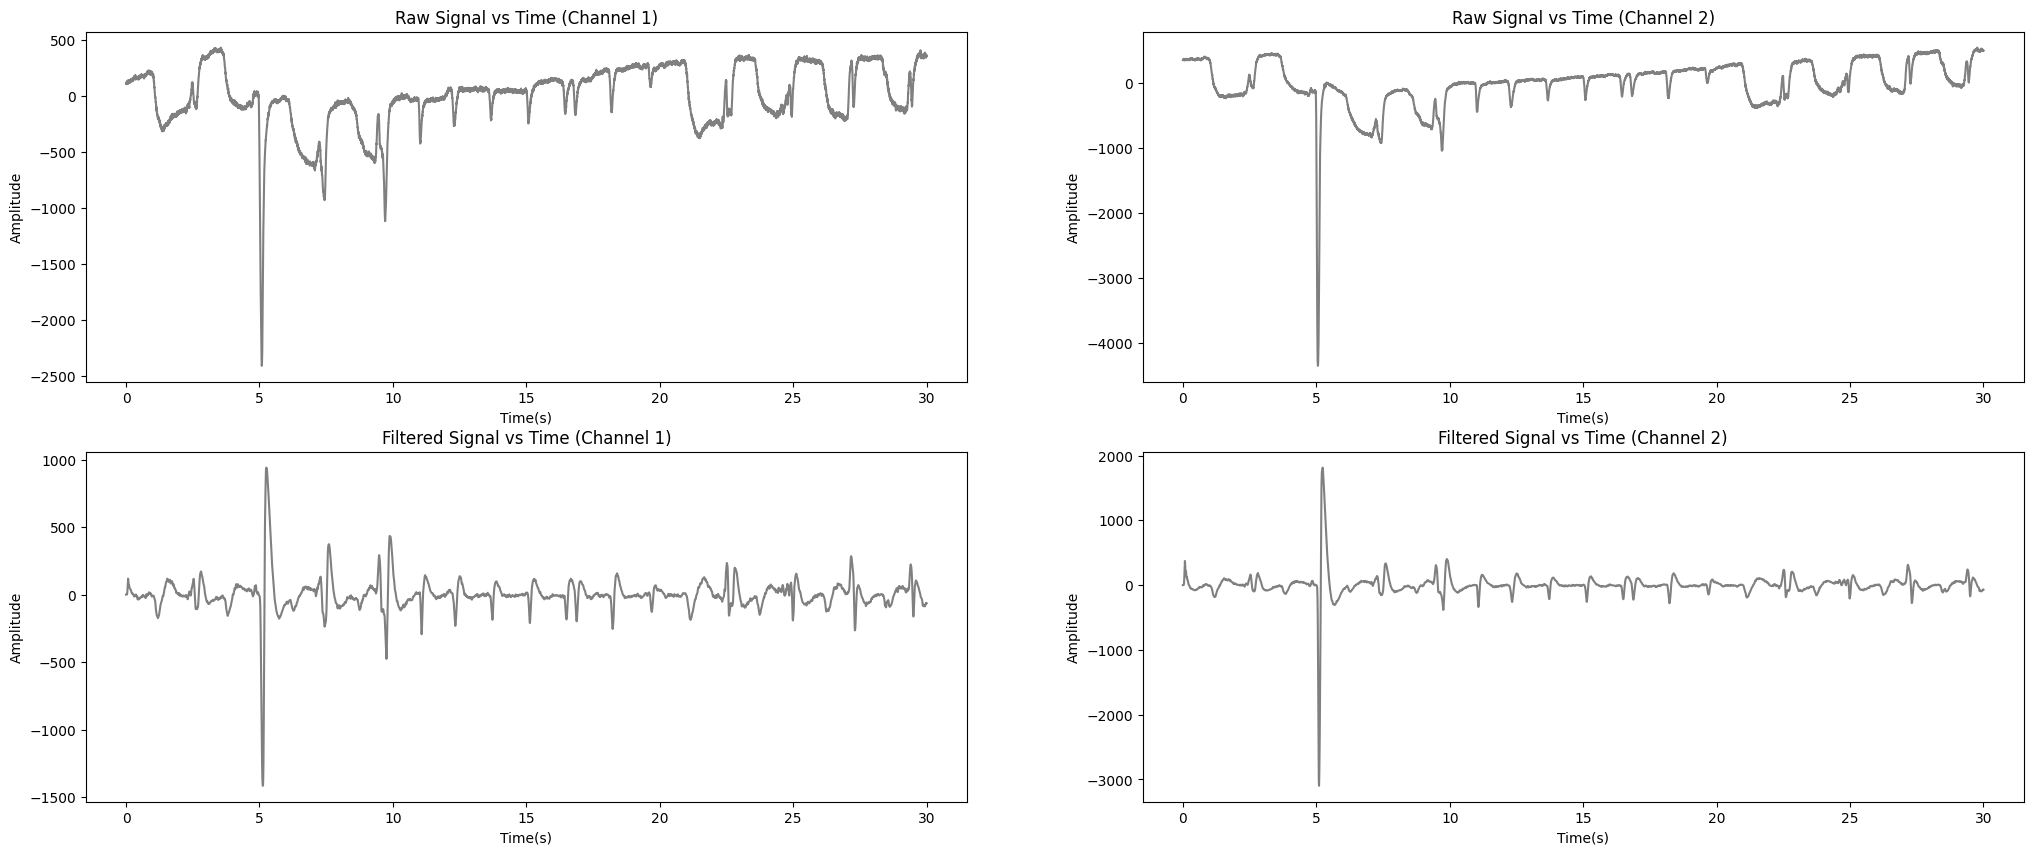

In [5]:
#Plotting in time
plt.figure(1, figsize=(25,10))
plt.subplot(221)
plt.plot(time1,pre_c1,"gray");plt.title("Raw Signal vs Time (Channel 1)");plt.xlabel("Time(s)");plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(time2,pre_c2,"gray");plt.title("Raw Signal vs Time (Channel 2)");plt.xlabel("Time(s)");plt.ylabel("Amplitude")

plt.subplot(223)
plt.plot(time1,fpre_c1,"gray");plt.title("Filtered Signal vs Time (Channel 1)");plt.xlabel("Time(s)");plt.ylabel("Amplitude")

plt.subplot(224)
plt.plot(time2,fpre_c2,"gray");plt.title("Filtered Signal vs Time (Channel 2)");plt.xlabel("Time(s)");plt.ylabel("Amplitude")

(0.0, 125.0)

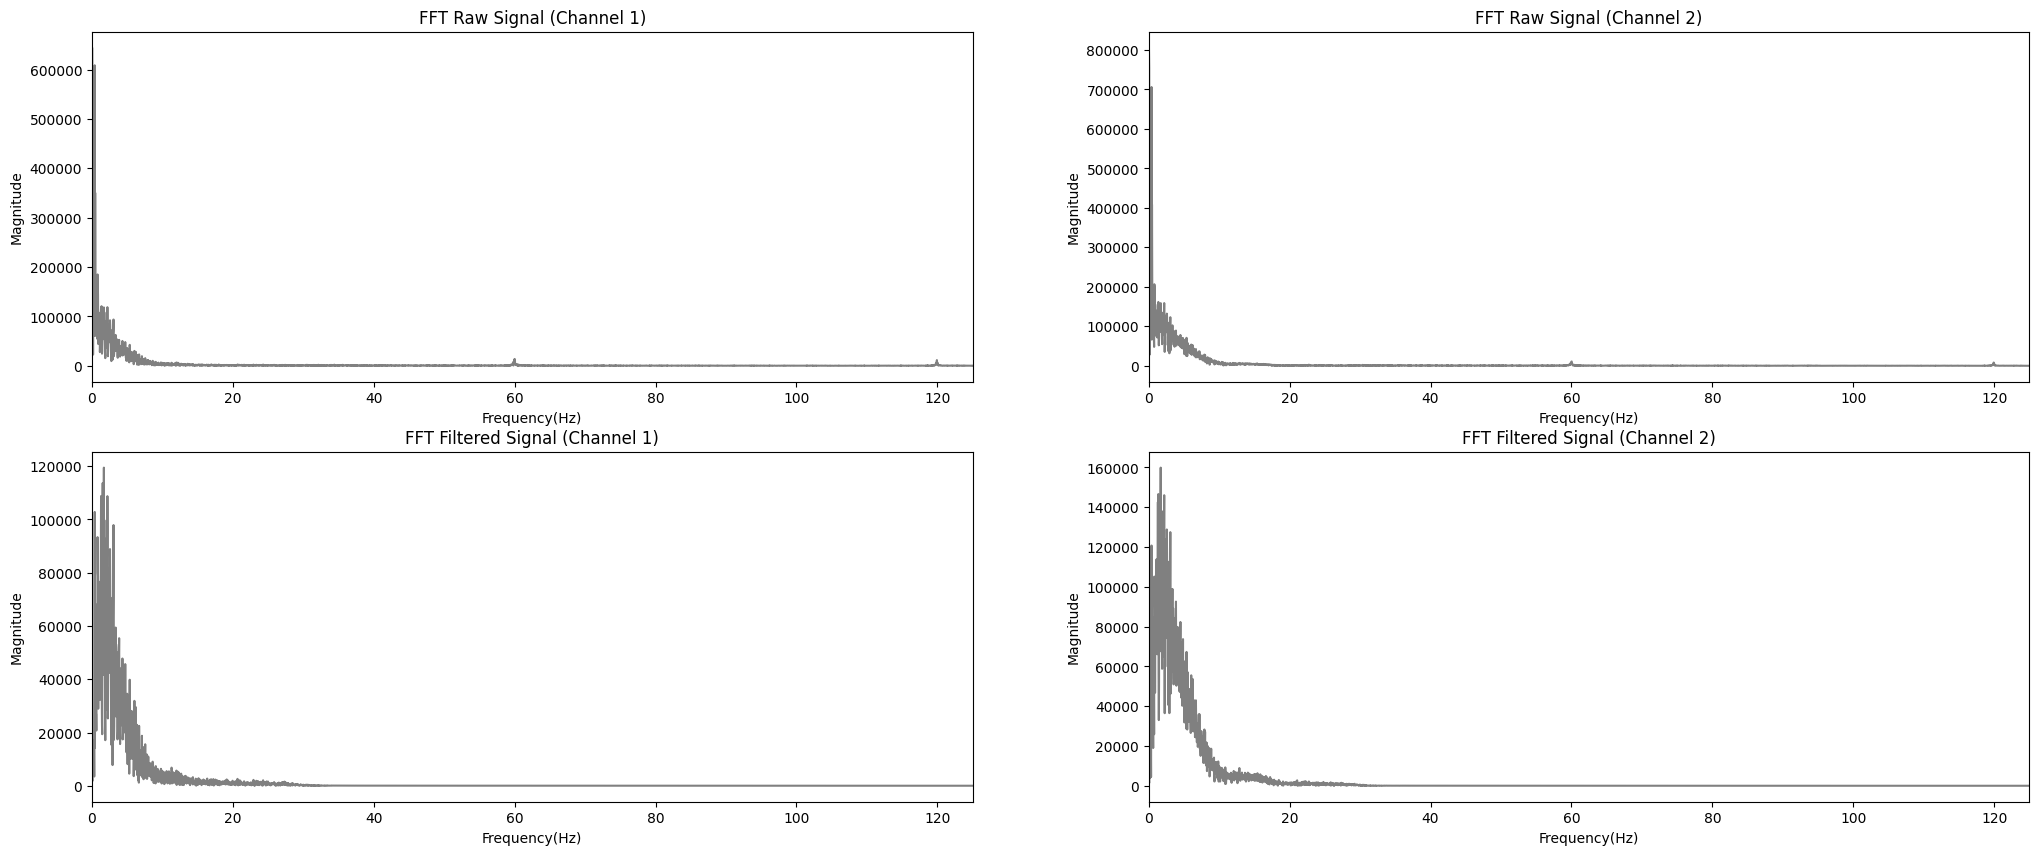

In [6]:
#Magnitude spectrum
s1_fft=abs(ft.fft(pre_c1))
wHz1=range_freq(pre_c1)

s2_fft=abs(ft.fft(pre_c2))
wHz2=range_freq(pre_c2)

fs1_fft=abs(ft.fft(fpre_c1))
wHzf1=range_freq(fpre_c1)

fs2_fft=abs(ft.fft(fpre_c2))
wHzf2=range_freq(fpre_c2)

#Frequency plotting
plt.figure(1, figsize=(25,10))
plt.subplot(221)
plt.plot(wHz1,s1_fft,"gray");plt.title("FFT Raw Signal (Channel 1)");plt.xlabel("Frequency(Hz)");plt.ylabel("Magnitude");plt.xlim([0,125])

plt.subplot(222)
plt.plot(wHz2,s2_fft,"gray");plt.title("FFT Raw Signal (Channel 2)");plt.xlabel("Frequency(Hz)");plt.ylabel("Magnitude");plt.xlim([0,125])

plt.subplot(223)
plt.plot(wHzf1,fs1_fft,"gray");plt.title("FFT Filtered Signal (Channel 1)");plt.xlabel("Frequency(Hz)");plt.ylabel("Magnitude");plt.xlim([0,125])

plt.subplot(224)
plt.plot(wHzf2,fs2_fft,"gray");plt.title("FFT Filtered Signal (Channel 2)");plt.xlabel("Frequency(Hz)");plt.ylabel("Magnitude");plt.xlim([0,125])

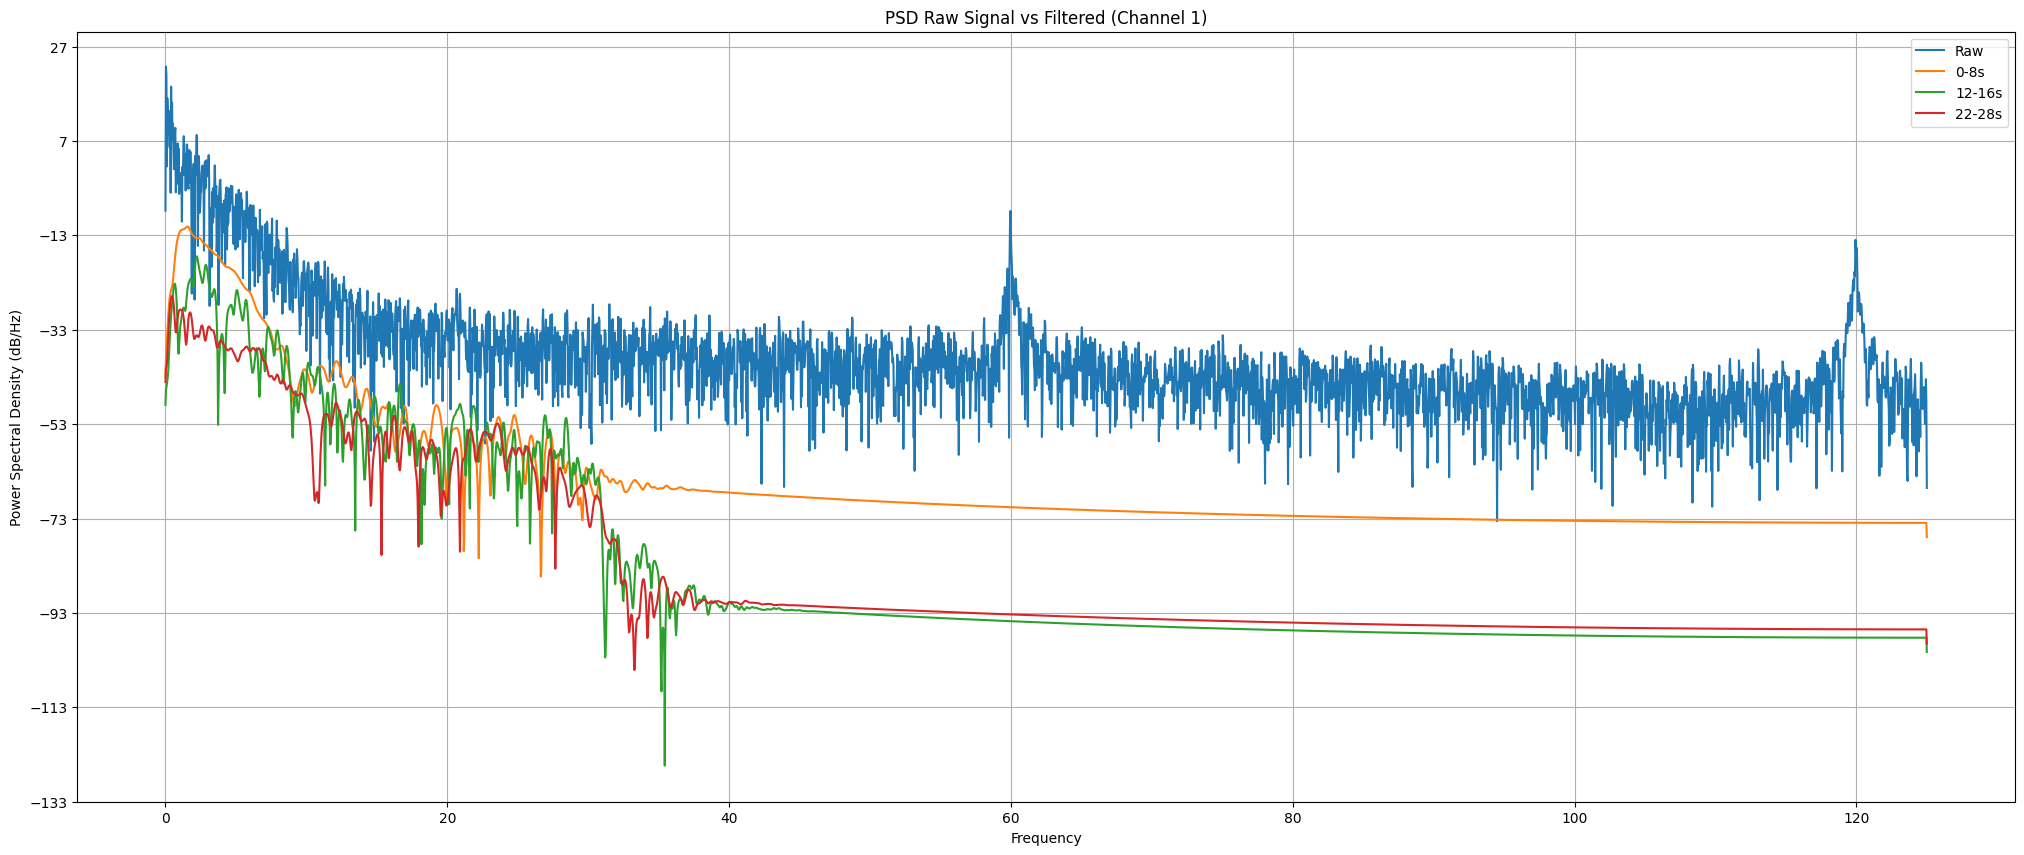

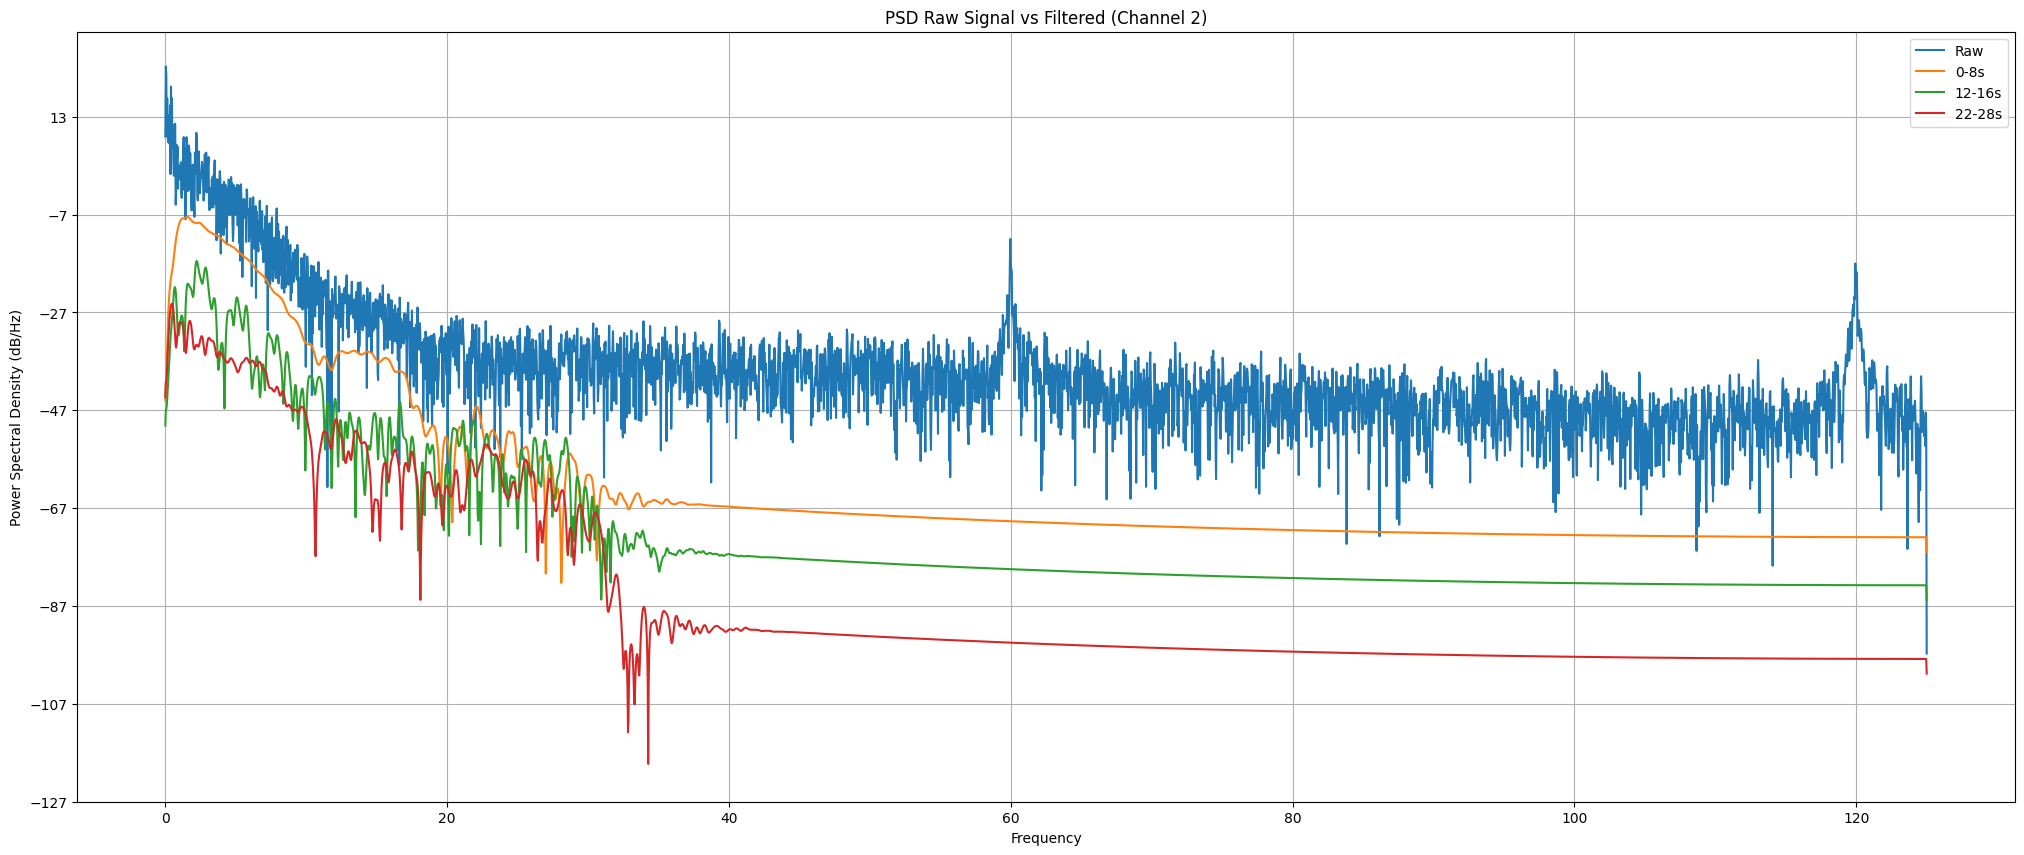

In [7]:
#Comparation
def db_to_mv (señal):
    s=10**(señal/20)
    return s
#Conversion a mV 
pre_c1_mv=pre_c1*0.02235
fpre_c1_mv=fpre_c1*0.02235

pre_c2_mv=pre_c2*0.02235
fpre_c2_mv=fpre_c2*0.02235

#Channel 1
plt.figure(4,figsize=(25,10))
#psd, frecuencias
[a11,a21]=plt.psd(pre_c1_mv,NFFT=len(pre_c1_mv),Fs=250)
plt.title("PSD Raw Signal vs Filtered (Channel 1)")

#PSD windows
#PSD frequency
[b11,b21]=plt.psd(fpre_c1_mv[2*250:6*250],NFFT=len(pre_c1_mv),Fs=250)

[c11,c21]=plt.psd(fpre_c1_mv[12*250:18*250],NFFT=len(pre_c1_mv),Fs=250)

[d11,d21]=plt.psd(fpre_c1_mv[22*250:26*250],NFFT=len(pre_c1_mv),Fs=250)
plt.legend(["Raw","0-8s","12-16s","22-28s"])

#Conversion a nuevo valor
#a1 y b2
filter_0_8_1=db_to_mv(b11)
filter_12_18_1=db_to_mv(c11)
filter_22_28_1=db_to_mv(d11)


#Channel 2
plt.figure(5,figsize=(25,10))
#psd, frecuencias
[a12,a22]=plt.psd(pre_c2_mv,NFFT=len(pre_c1_mv),Fs=250)
plt.title("PSD Raw Signal vs Filtered (Channel 2)")

#PSD VENTANA 1

[b12,b22]=plt.psd(fpre_c2_mv[2*250:6*250],NFFT=len(pre_c1_mv),Fs=250)

[c12,c22]=plt.psd(fpre_c2_mv[12*250:18*250],NFFT=len(pre_c1_mv),Fs=250)

[d12,d22]=plt.psd(fpre_c2_mv[22*250:26*250],NFFT=len(pre_c1_mv),Fs=250)
plt.legend(["Raw","0-8s","12-16s","22-28s"])

#Conversion a nuevo valor
#a1 y b2
filter_0_8_2=db_to_mv(b12)
filter_12_18_2=db_to_mv(c12)
filter_22_28_2=db_to_mv(d12)

Text(0.5, 0, 'Frequencies')

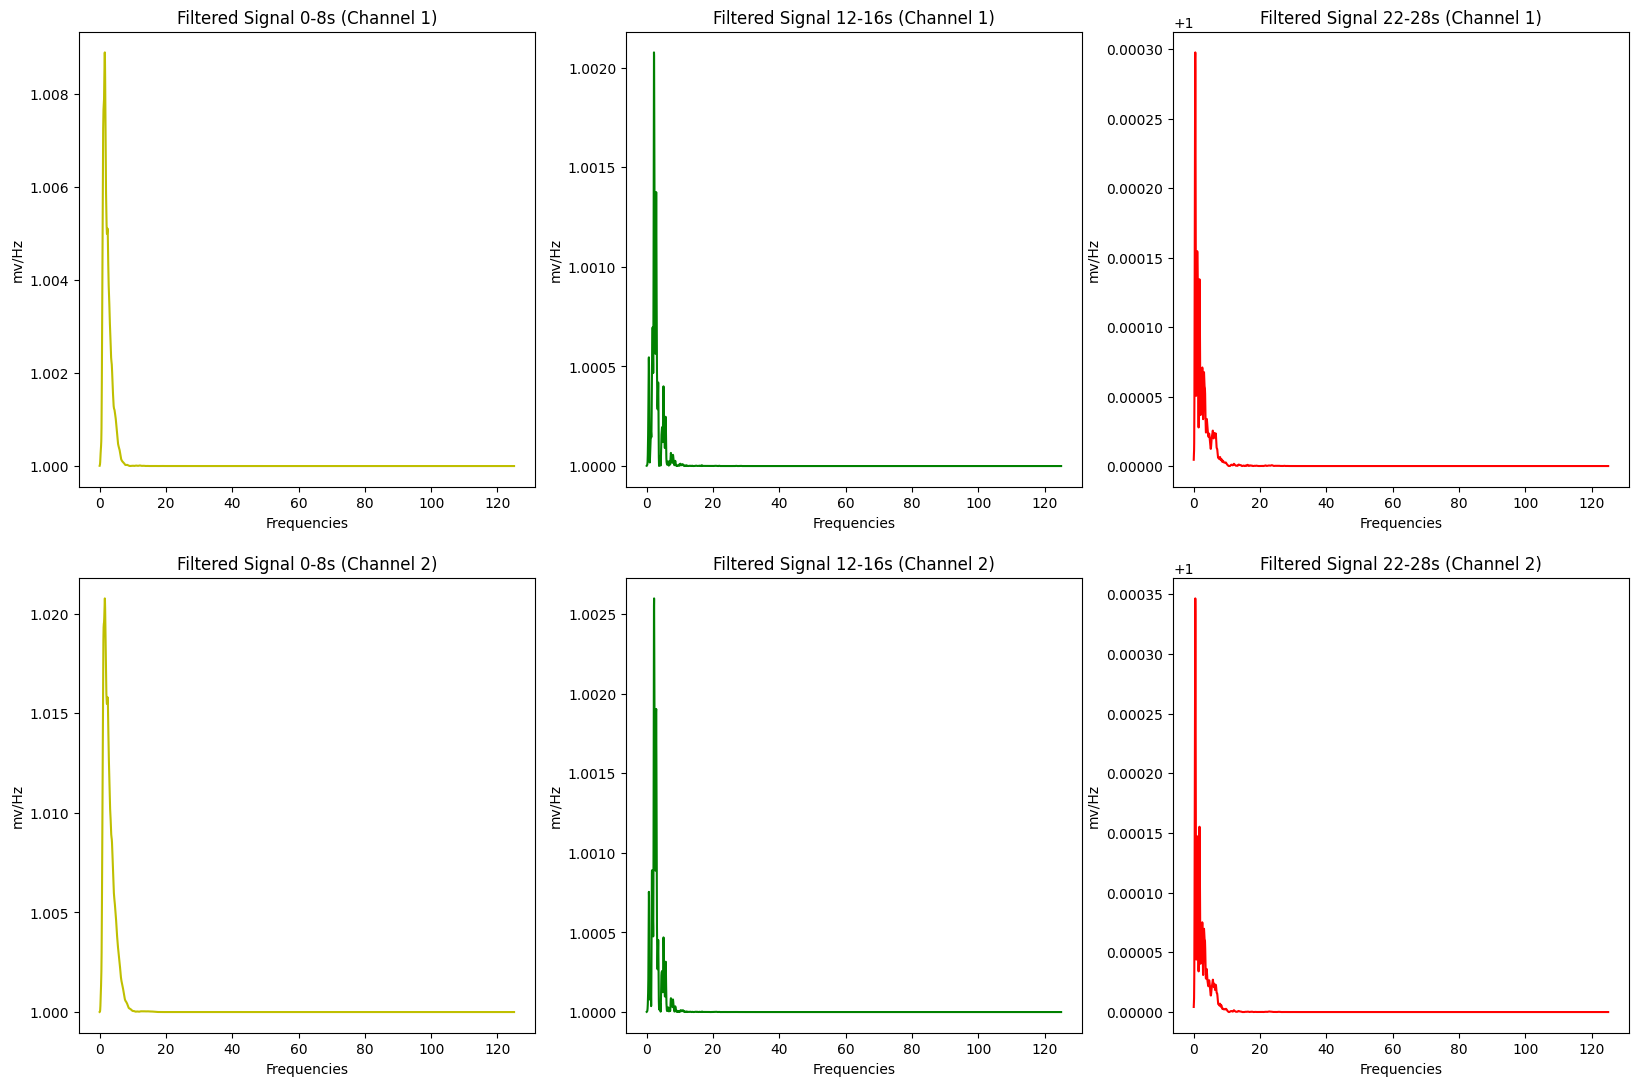

In [8]:
plt.figure(6, figsize=(20,13))
plt.subplot(231)
plt.plot(b21,filter_0_8_1,"y");plt.title("Filtered Signal 0-8s (Channel 1)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")
plt.subplot(232)
plt.plot(c21,filter_12_18_1,"g");plt.title("Filtered Signal 12-16s (Channel 1)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")
plt.subplot(233)
plt.plot(d21,filter_22_28_1,"r");plt.title("Filtered Signal 22-28s (Channel 1)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")
plt.subplot(234)
plt.plot(b22,filter_0_8_2,"y");plt.title("Filtered Signal 0-8s (Channel 2)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")
plt.subplot(235)
plt.plot(c22,filter_12_18_2,"g");plt.title("Filtered Signal 12-16s (Channel 2)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")
plt.subplot(236)
plt.plot(d22,filter_22_28_2,"r");plt.title("Filtered Signal 22-28s (Channel 2)");plt.ylabel("mv/Hz");plt.xlabel("Frequencies")

In [9]:
#Finding the parameter w
def n1_n2(freq,amp):
    n1=0.0;n2=0.0
    val_3_8=[];val_8_13=[];val_13_18=[]
    for i in range(len(freq)):
        if 3.0<=freq[i]<8.0:
            if amp[i]!=0.0:
                n1+=1.0
                val_3_8.append(amp[i])
        if 8.0<=freq[i]<13.0:
            if amp[i]!=0.0:
                val_8_13.append(amp[i])
        if 13.0<=freq[i]<=18.0:
            if amp[i]!=0.0:
                n2+=1.0
                val_13_18.append(amp[i])
                
    max_8_13=max(val_8_13);sum_3_8=sum(val_3_8);sum_13_18=sum(val_13_18)
    return (n1+n2),max_8_13,sum_3_8,sum_13_18

#Channel 1
print("Channel 1")
N,max_8_13,sum_3_8,sum_13_18=n1_n2(b21,filter_0_8_1)

w1=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 0-8:",w1)


N,max_8_13,sum_3_8,sum_13_18=n1_n2(c21,filter_12_18_1)

w2=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 12-16:",w2)


N,max_8_13,sum_3_8,sum_13_18=n1_n2(d21,filter_22_28_1)

w3=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 22-28:",w3)

#Channel 2
print("\nChannel 2")
N,max_8_13,sum_3_8,sum_13_18=n1_n2(b22,filter_0_8_2)

w4=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 0-8:",w4)


N,max_8_13,sum_3_8,sum_13_18=n1_n2(c22,filter_12_18_2)

w5=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 12-16:",w5)


N,max_8_13,sum_3_8,sum_13_18=n1_n2(d22,filter_22_28_2)

w6=(2*(N)*max_8_13)/(sum_3_8 +sum_13_18)
print("Valor 22-28:",w6)

Channel 1
Valor 0-8: 1.9991694277480219
Valor 12-16: 1.999970955018142
Valor 22-28: 1.999988683603155

Channel 2
Valor 0-8: 1.9968459539882186
Valor 12-16: 1.9999827823836807
Valor 22-28: 1.9999880067451679


In [15]:
#Guardar el dataset:
import json

#final={"Señal filtrada":filtered_signal_3_30,"Valor 0-8":w1,"Valor 12-18":w2,"Valor 22-28":w3}

#señal=filtered_signal_3_30.reshape(len(filtered_signal_3_30),1)
#print(señal.shape)
final={"Señal filtrada CC0 C1":fpre_c1.tolist(),"Valor 0-8 C1":w1,"Valor 12-18 C1":w2,"Valor 22-28 C1":w3, "Señal filtrada CC0 C2":fpre_c2.tolist(),"Valor 0-8 C1":w4,"Valor 12-18 C2":w5,"Valor 22-28 C3":w6}
with open("final_dataset.txt", 'r') as final_dataset:
    contenido_archivo2 = final_dataset.read()

with open("FINAL_OCO.txt", 'w') as final_dataset:
    a1=str(fpre_c1)+"\n"
    a2="Valor 0-8 CC0 CHANNEL 1: "+str(w1)+"\n"
    a3="Valor 12-18 CC0 CHANNEL 1: "+str(w2)+"\n"
    a4="Valor 22-28 CC0 CHANNEL 1: "+str(w3)+"\n"
    a5=str(fpre_c1)+"\n"
    a6="Valor 0-8 CC0 CHANNEL 2: "+str(w4)+"\n"
    a7="Valor 12-18 CC0 CHANNEL 2: "+str(w5)+"\n"
    a8="Valor 22-28 CC0 CHANNEL 2: "+str(w6)+"\n"
    final_dataset.write(a1)
    final_dataset.write(a2)
    final_dataset.write(a3)
    final_dataset.write(a4)
    final_dataset.write(a5)
    final_dataset.write(a6)
    final_dataset.write(a7)
    final_dataset.write(a8)
    final_dataset.write("\n")



with open("data2.json","w") as archivo:
    json.dump(final,archivo)

A higher w value is expected when the eyes are closed than when they are open.In this case it is true, since in the 0-8s and 22-28s window (eyes open) it has a lower value of w than in the 12-16s window (eyes close).